In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patchworklib as pw
import pingouin as pg
import seaborn as sns
import xarray as xr
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

plt.style.use("papers")
pw.overwrite_axisgrid()
REAL_FOLDER = "../../results/aggregated/"

DATA_TYPE = "real_data"

COLUMNS_ORDER = [
    "AAHC",
    "TAAHC",
    "mod. K-Means",
    "HMM",
    "PCA",
    "ICA",
]

DATA_ORDER = ["real data", "shuffle", "FT", "AAFT", "IAAFT"]

EOC = "EC"

<Figure size 72x72 with 0 Axes>

In [2]:
real_stats = pd.read_csv(os.path.join(REAL_FOLDER, "stats.csv"))
real_stats = real_stats[real_stats["data_type"] == EOC]
real_stats = real_stats.rename(
    columns={
        "decomposition_type": "algorithm",
        "AIF 1st peak [ms]": "AIF 1st peak",
        "surrogate_type": "surrogate type",
    }
).replace({"hmm": "HMM", "kmeans": "mod. K-Means", "real_data": "real data"})
real_stats = real_stats.sort_values(by="algorithm")
real_stats = (
    real_stats.rename(columns={"var_GFP": "var GFP", "var_total": "var total"})
    .set_index("algorithm")
    .loc[COLUMNS_ORDER]
    .reset_index()
)

In [3]:
def get_df_per_map(measure):
    df_mean = (
        real_stats.pivot(
            index=["subject_id", "latent map"],
            columns=["surrogate type", "algorithm"],
            values=measure,
        )
        .groupby("latent map")
        .corr()
        .unstack(level=[-1, -2])
        .mean()
    )
    df_mean.index.names = ["data1", "algorithm1", "algorithm2", "data2"]
    measure_df = (
        df_mean.reset_index()
        .pivot(index=["data1", "algorithm1"], columns=["data2", "algorithm2"], values=0)
        .sort_index(axis=1)
    )

    multicol_order = [(data, alg) for data in DATA_ORDER for alg in COLUMNS_ORDER]

    measure_df = measure_df.loc[multicol_order, multicol_order]

    measure_df.columns = measure_df.columns.droplevel(0)
    measure_df.index = measure_df.index.droplevel(0)
    return measure_df


def get_df(measure):
    df_mean = (
        real_stats.drop_duplicates(
            ["subject_id", "surrogate type", "algorithm", measure]
        )
        .pivot(
            index="subject_id",
            columns=["surrogate type", "algorithm"],
            values=measure,
        )
        .corr()
    )

    multicol_order = [(data, alg) for data in DATA_ORDER for alg in COLUMNS_ORDER]

    measure_df = df_mean.loc[multicol_order, multicol_order]

    measure_df.columns = measure_df.columns.droplevel(0)
    measure_df.index = measure_df.index.droplevel(0)
    return measure_df

In [4]:
measure = get_df_per_map("lifespan")
g1 = pw.Brick("ax1", figsize=(18, 18))
sns.heatmap(
    measure,
    square=True,
    annot=True,
    fmt=".2f",
    vmin=-1,
    vmax=1,
    cmap="bwr",
    ax=g1,
)
g1.set_ylabel("")
g1.set_xlabel("")
g1.set_title("Lifespan")
for line in np.arange(6, measure.shape[0], 6):
    g1.axes.axhline(line, color="k")
    g1.axes.axvline(line, color="k")
for pos, method in enumerate(DATA_ORDER):
    g1.axes.text(-5, 3 + 6 * pos, method, size=30, ha="left", rotation=90, va="center")
    g1.axes.text(3 + 6 * pos, 35, method, size=30, ha="center")

measure = get_df_per_map("occurrence")
g2 = pw.Brick("ax2", figsize=(18, 18))
sns.heatmap(
    measure,
    square=True,
    annot=True,
    fmt=".2f",
    vmin=-1,
    vmax=1,
    cmap="bwr",
    ax=g2,
)
g2.set_ylabel("")
g2.set_xlabel("")
g2.set_title("Occurrence")
for line in np.arange(6, measure.shape[0], 6):
    g2.axes.axhline(line, color="k")
    g2.axes.axvline(line, color="k")
for pos, method in enumerate(DATA_ORDER):
    g2.axes.text(-5, 3 + 6 * pos, method, size=30, ha="left", rotation=90, va="center")
    g2.axes.text(3 + 6 * pos, 35, method, size=30, ha="center")

measure = get_df_per_map("coverage")
g3 = pw.Brick("ax3", figsize=(18, 18))
sns.heatmap(
    measure,
    square=True,
    annot=True,
    fmt=".2f",
    vmin=-1,
    vmax=1,
    cmap="bwr",
    ax=g3,
)
g3.set_ylabel("")
g3.set_xlabel("")
g3.set_title("Coverage")
for line in np.arange(6, measure.shape[0], 6):
    g3.axes.axhline(line, color="k")
    g3.axes.axvline(line, color="k")
for pos, method in enumerate(DATA_ORDER):
    g3.axes.text(-5, 3 + 6 * pos, method, size=30, ha="left", rotation=90, va="center")
    g3.axes.text(3 + 6 * pos, 35, method, size=30, ha="center")

measure = get_df_per_map("var GFP")
g4 = pw.Brick("ax4", figsize=(18, 18))
sns.heatmap(
    measure,
    square=True,
    annot=True,
    fmt=".2f",
    vmin=-1,
    vmax=1,
    cmap="bwr",
    ax=g4,
)
g4.set_ylabel("")
g4.set_xlabel("")
g4.set_title("Variance GFP")
for line in np.arange(6, measure.shape[0], 6):
    g4.axes.axhline(line, color="k")
    g4.axes.axvline(line, color="k")
for pos, method in enumerate(DATA_ORDER):
    g4.axes.text(-5, 3 + 6 * pos, method, size=30, ha="left", rotation=90, va="center")
    g4.axes.text(3 + 6 * pos, 35, method, size=30, ha="center")

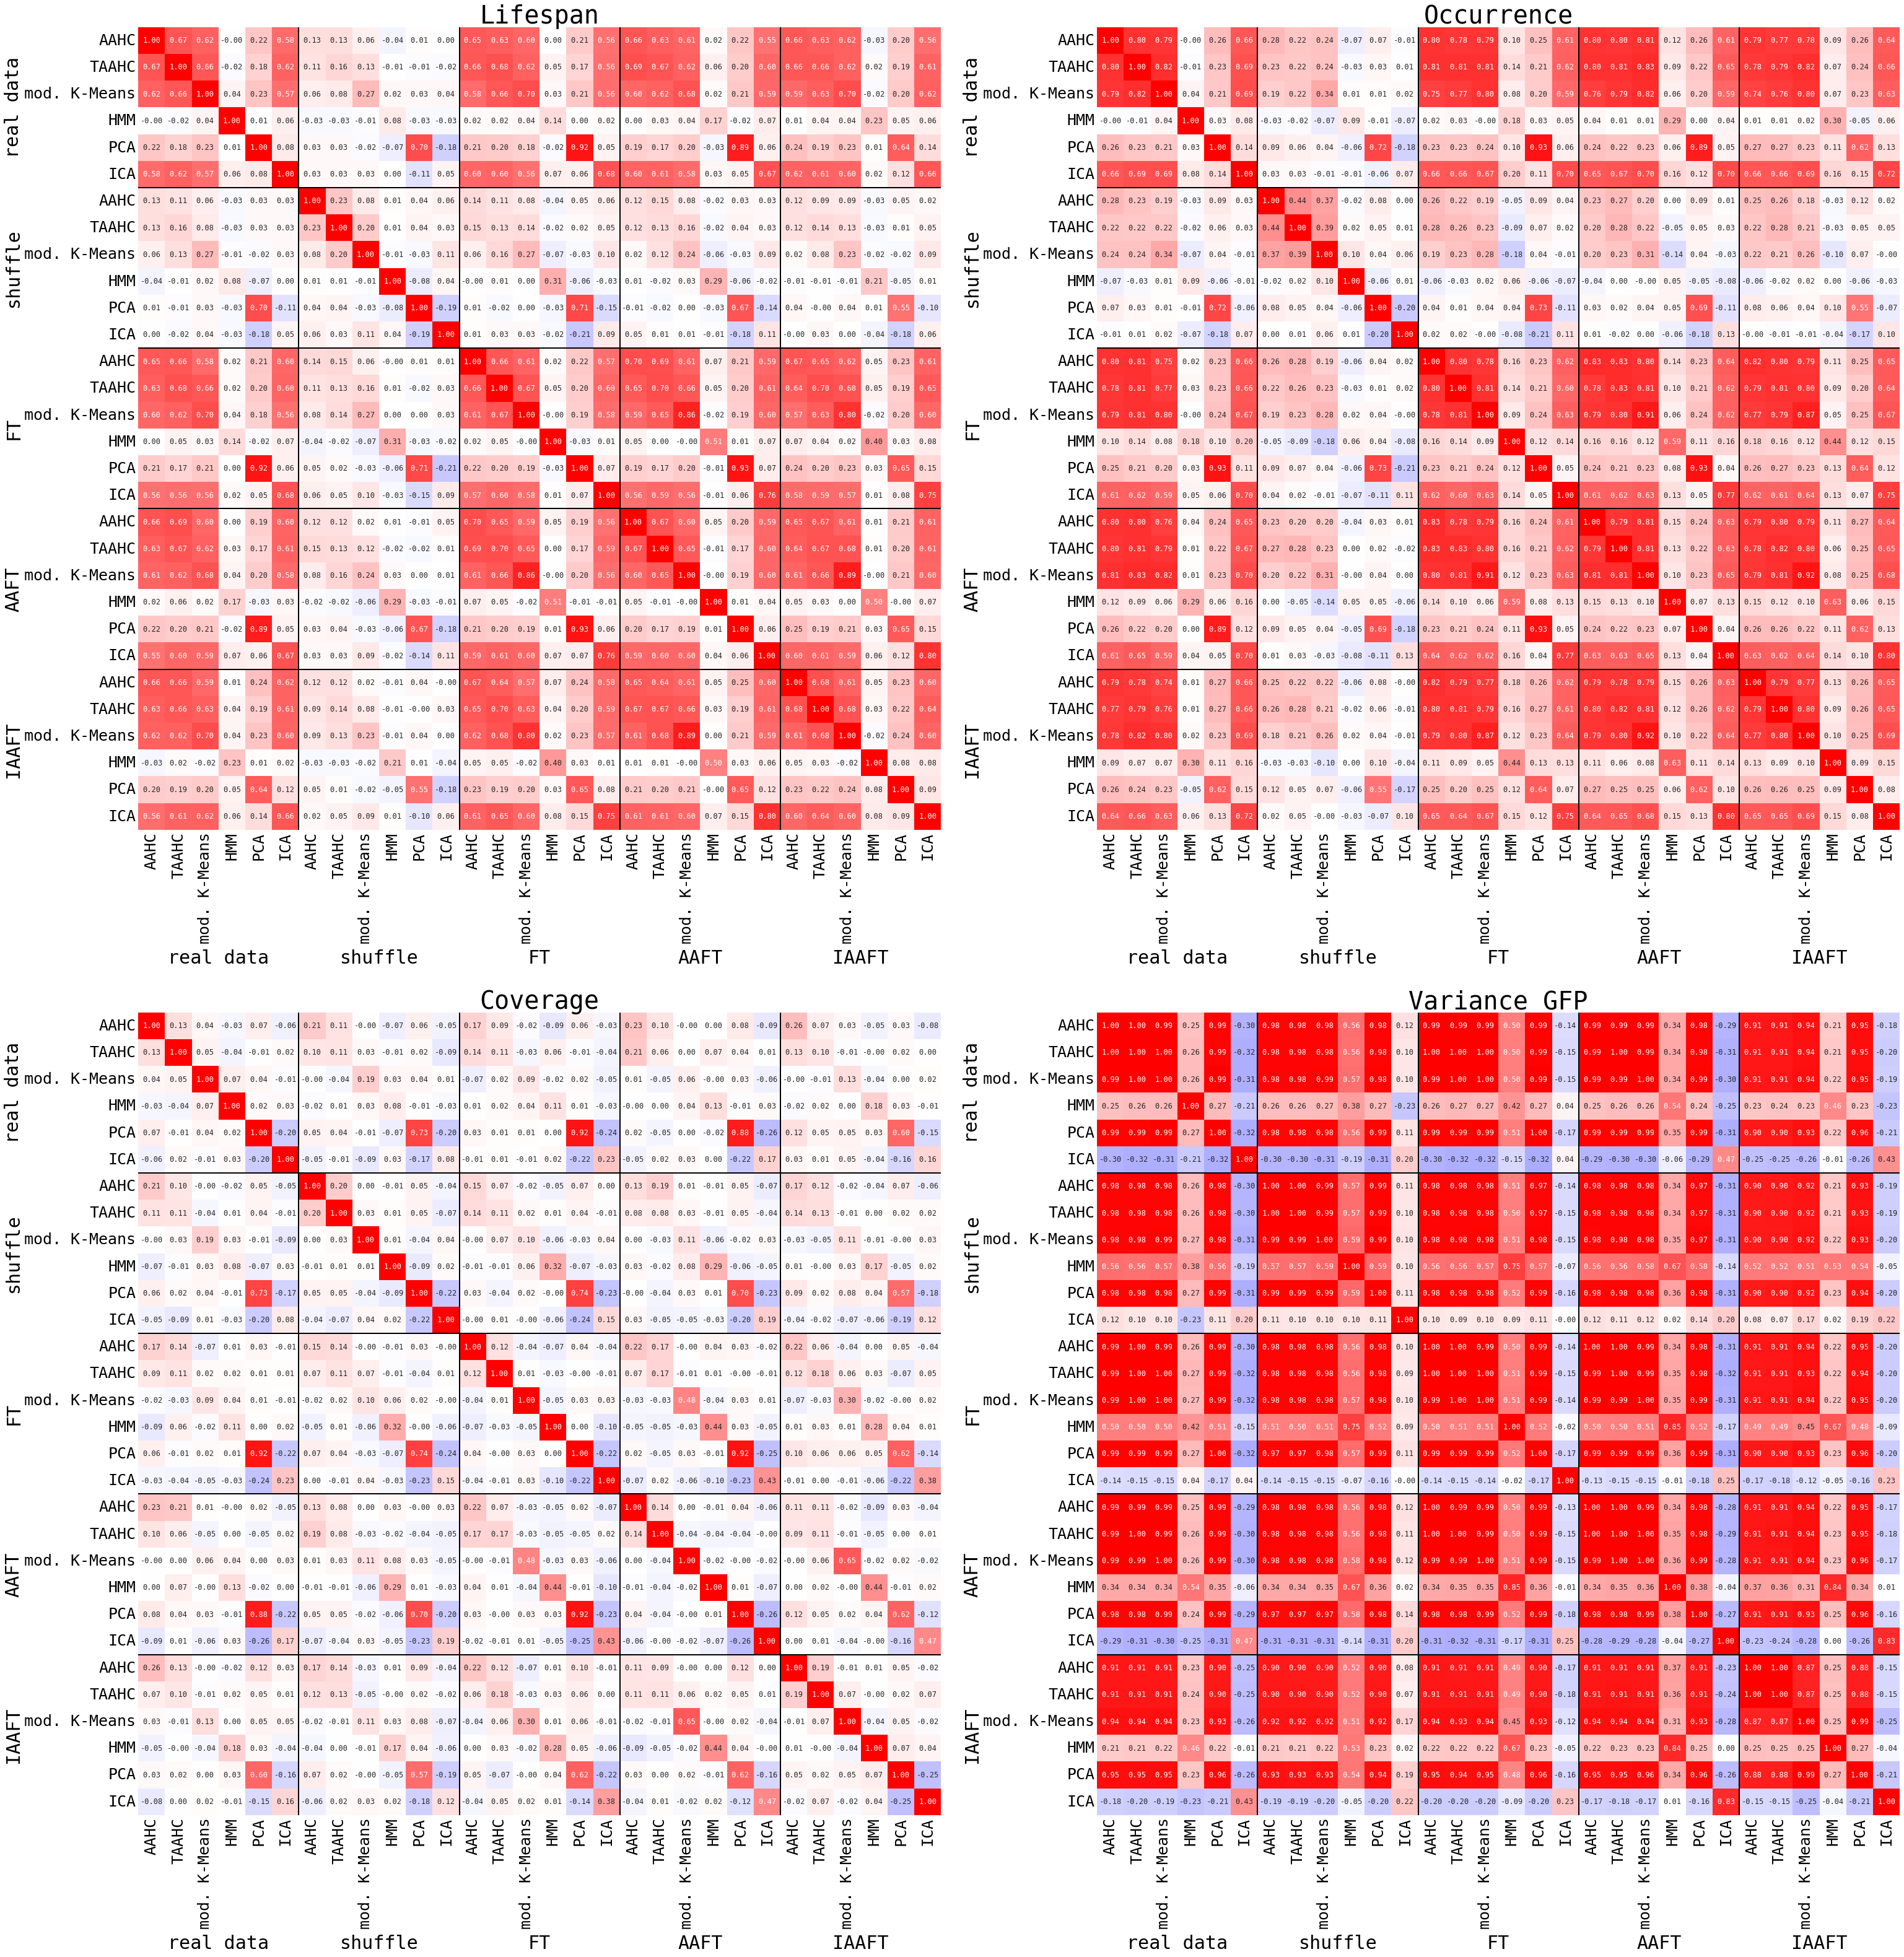

In [5]:
((g1 | g2) / (g3 | g4)).savefig(fname="real_vs_surrogates_static.pdf", transparent=True)

In [6]:
measure = get_df("mixing time")
g5 = pw.Brick("ax5", figsize=(18, 18))
sns.heatmap(
    measure,
    square=True,
    annot=True,
    fmt=".2f",
    vmin=-1,
    vmax=1,
    cmap="bwr",
    ax=g5,
)
g5.set_ylabel("")
g5.set_xlabel("")
g5.set_title("Mixing time")
for line in np.arange(6, measure.shape[0], 6):
    g5.axes.axhline(line, color="k")
    g5.axes.axvline(line, color="k")
for pos, method in enumerate(DATA_ORDER):
    g5.axes.text(-5, 3 + 6 * pos, method, size=30, ha="left", rotation=90, va="center")
    g5.axes.text(3 + 6 * pos, 35, method, size=30, ha="center")

measure = get_df("entropy")
g6 = pw.Brick("ax6", figsize=(18, 18))
sns.heatmap(
    measure,
    square=True,
    annot=True,
    fmt=".2f",
    vmin=-1,
    vmax=1,
    cmap="bwr",
    ax=g6,
)
g6.set_ylabel("")
g6.set_xlabel("")
g6.set_title("Entropy")
for line in np.arange(6, measure.shape[0], 6):
    g6.axes.axhline(line, color="k")
    g6.axes.axvline(line, color="k")
for pos, method in enumerate(DATA_ORDER):
    g6.axes.text(-5, 3 + 6 * pos, method, size=30, ha="left", rotation=90, va="center")
    g6.axes.text(3 + 6 * pos, 35, method, size=30, ha="center")

measure = get_df("AIF 1st peak")
g7 = pw.Brick("ax7", figsize=(18, 18))
sns.heatmap(
    measure,
    square=True,
    annot=True,
    fmt=".2f",
    vmin=-1,
    vmax=1,
    cmap="bwr",
    ax=g7,
)
g7.set_ylabel("")
g7.set_xlabel("")
g7.set_title("AIF 1st peak")
for line in np.arange(6, measure.shape[0], 6):
    g7.axes.axhline(line, color="k")
    g7.axes.axvline(line, color="k")
for pos, method in enumerate(DATA_ORDER):
    g7.axes.text(-5, 3 + 6 * pos, method, size=30, ha="left", rotation=90, va="center")
    g7.axes.text(3 + 6 * pos, 35, method, size=30, ha="center")

measure = get_df("entropy rate")
g8 = pw.Brick("ax8", figsize=(18, 18))
sns.heatmap(
    measure,
    square=True,
    annot=True,
    fmt=".2f",
    vmin=-1,
    vmax=1,
    cmap="bwr",
    ax=g8,
)
g8.set_ylabel("")
g8.set_xlabel("")
g8.set_title("Entropy rate")
for line in np.arange(6, measure.shape[0], 6):
    g8.axes.axhline(line, color="k")
    g8.axes.axvline(line, color="k")
for pos, method in enumerate(DATA_ORDER):
    g8.axes.text(-5, 3 + 6 * pos, method, size=30, ha="left", rotation=90, va="center")
    g8.axes.text(3 + 6 * pos, 35, method, size=30, ha="center")

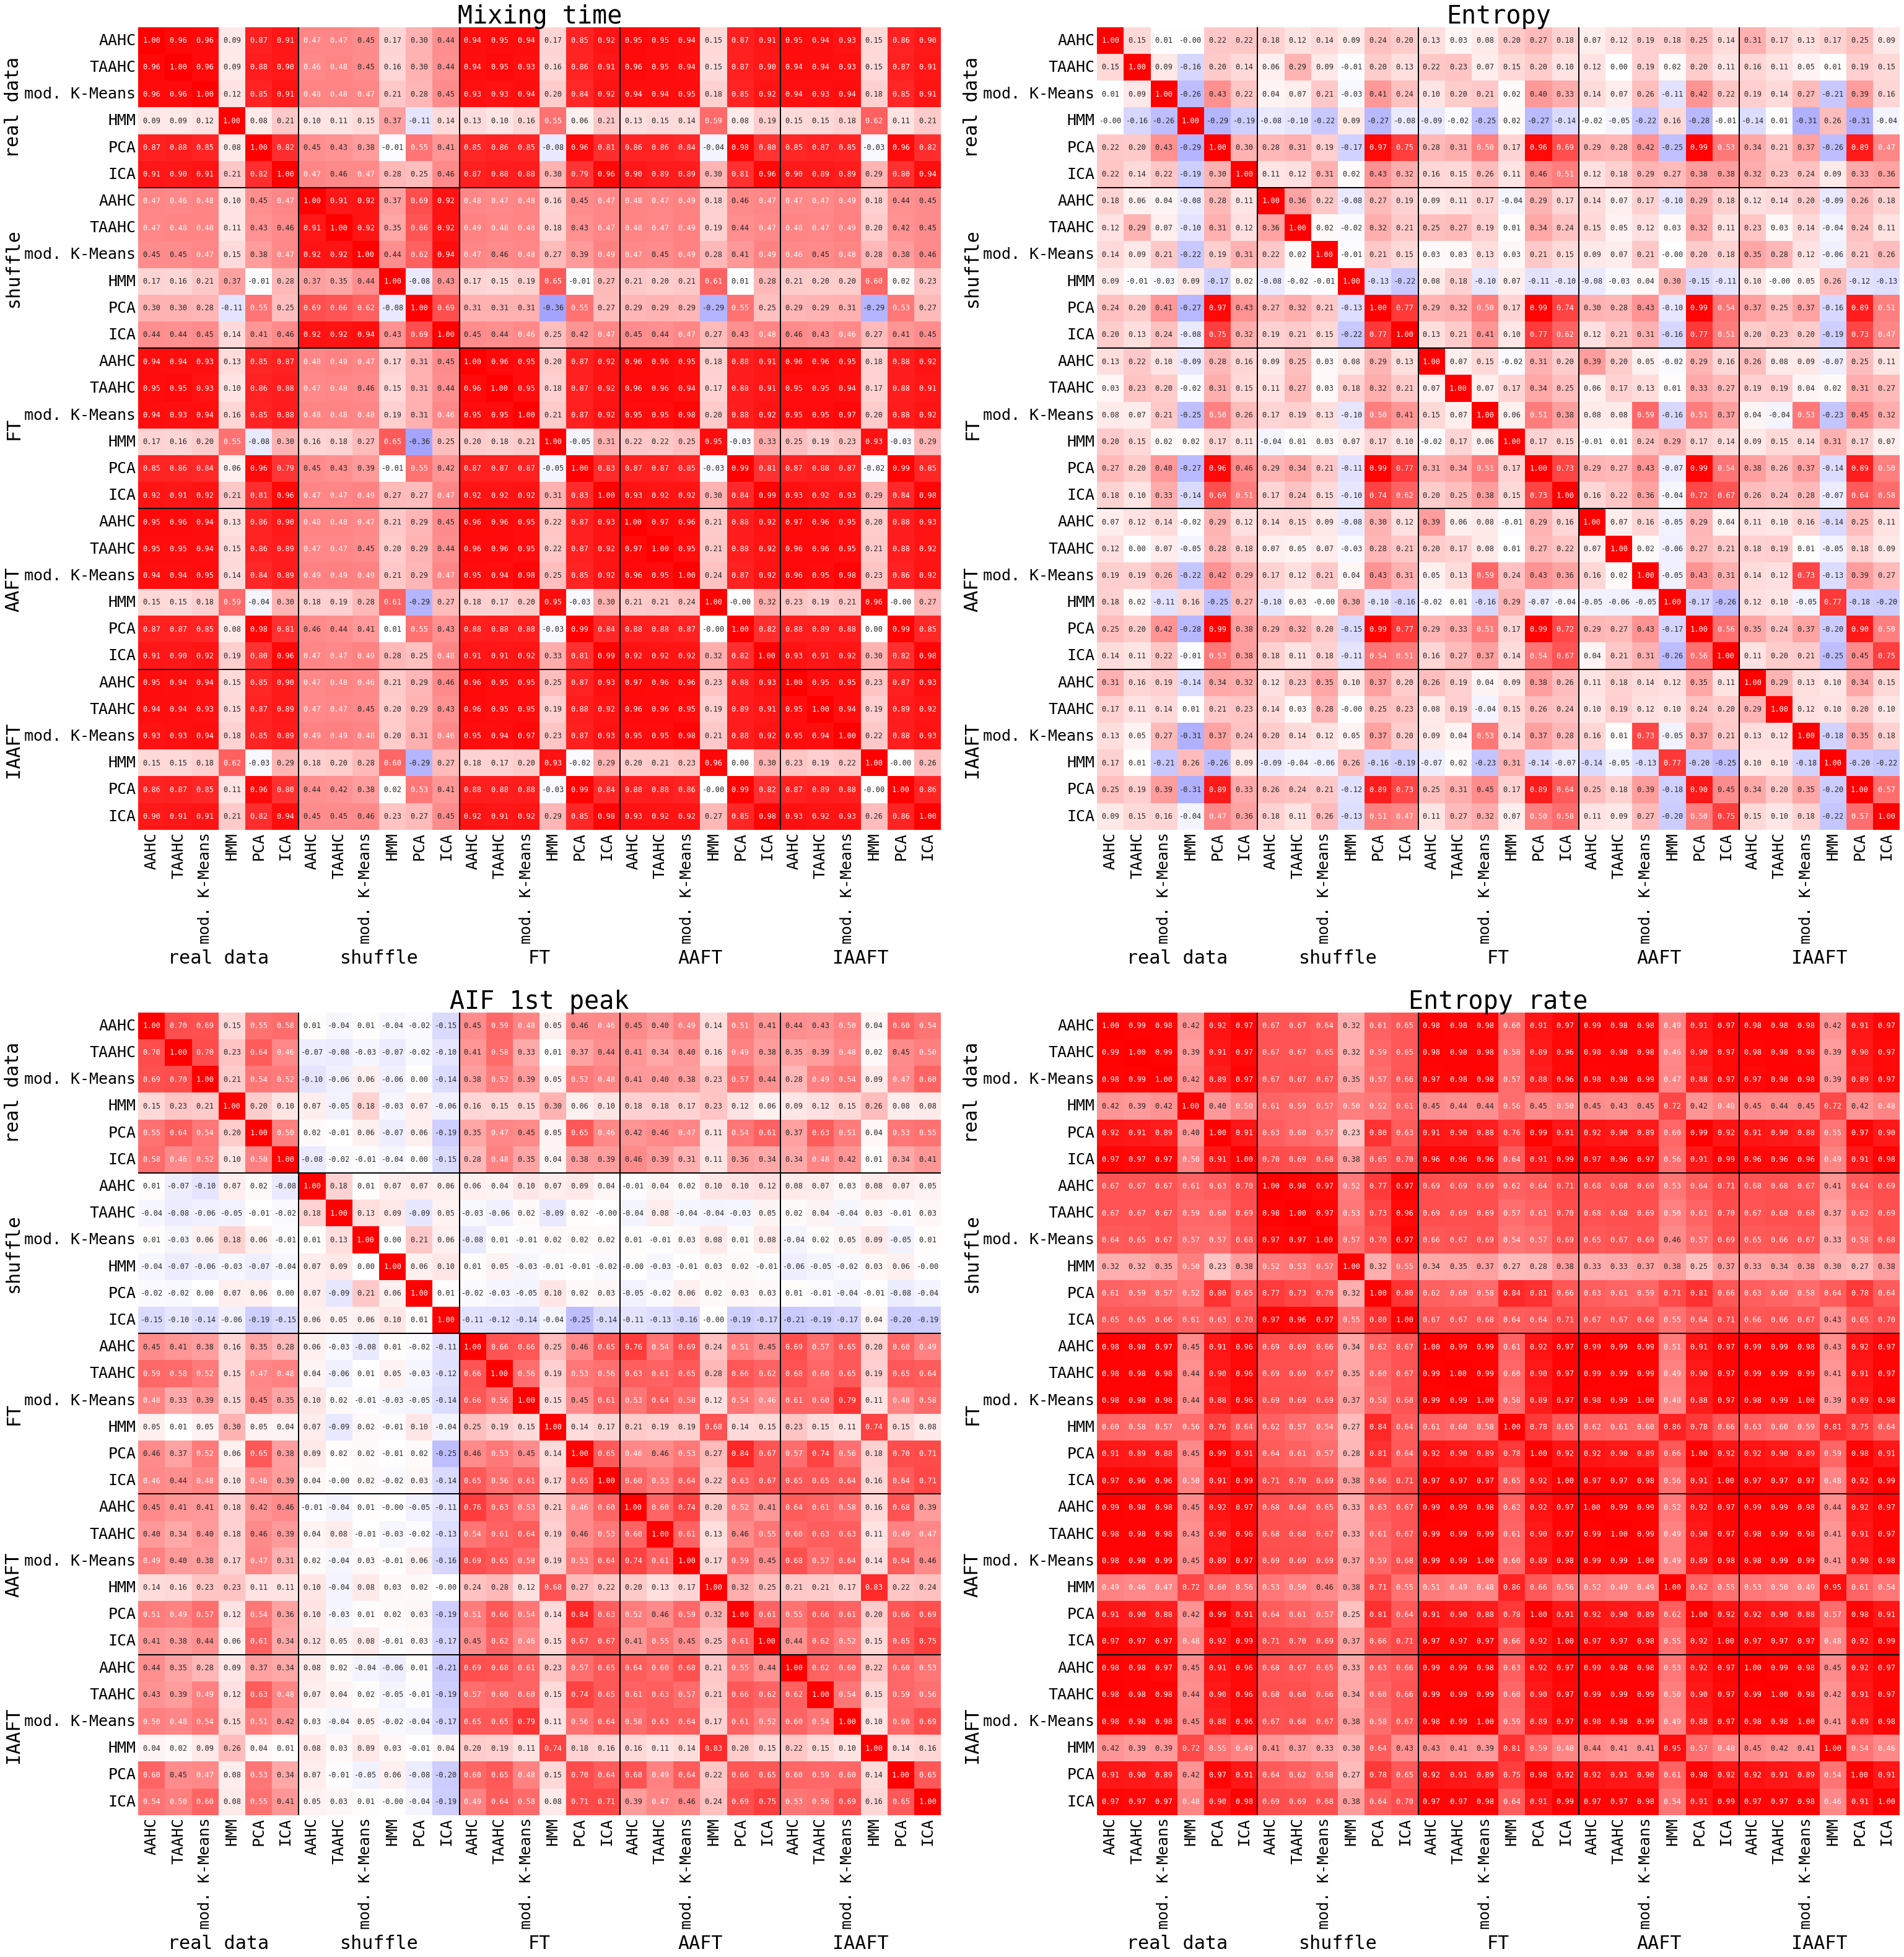

In [7]:
((g5 | g6) / (g7 | g8)).savefig(fname="real_vs_surrogates_inf.pdf", transparent=True)